In [198]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
from shapely.geometry import Point
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from pysal.lib import weights
from libpysal.io import open as psopen
# import plots
import seaborn as sns
from datetime import datetime
import jenkspy

In [199]:

country = 'Colombia'

if country=='Argentina':
    country_short = 'ARG'
    country_code = 'AR'
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
elif country == 'Mexico':
    country_short = 'MEX'
    country_code = 'MX'


directory = '/Volumes/RECAST/data/outputs/latin-mobility-covid/' + country_short
wd = '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/Research/RECAST/latin-mobility-covid-local-files' 



In [200]:
movcell_baseline_imput_pop = gpd.read_file(wd + '/data/outputs/' + country_short + '/grids-with-data/movcell-baseline-imput-pop/movcell-baseline-imput-pop.gpkg')



### Merge movcell baseline input pop with WP population via spatial join

In [201]:
# Import worldpop raster and turn it into geodataframe of points based on centroids of pixels
rds = rx.open_rasterio(wd + '/data/inputs/population/worldpop/' + country_short.lower() + '_ppp_2020_1km_Aggregated.tif')
rds.name = "population"

df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
gdf_worldpop = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)

gdf_worldpop = gdf_worldpop.drop(['y', 'x', 'band', 'spatial_ref'], axis = 1)



In [202]:
# Drop geometries from gdf_worldpop where the population value is not well-defined
gdf_worldpop = gdf_worldpop[gdf_worldpop['population'] != -99999].reset_index(drop=True)
gdf_worldpop = gdf_worldpop.to_crs('EPSG:4326')


In [203]:
grid_wp = gpd.sjoin(movcell_baseline_imput_pop, gdf_worldpop)
grid_wp_group = grid_wp[['population']].groupby(grid_wp[['population']].index).sum()


In [204]:
movcell_baseline_imput_pop = pd.merge(movcell_baseline_imput_pop, grid_wp_group, how='left', left_index=True, right_index=True)


In [205]:
if country == 'Mexico':
    id_problem = movcell_baseline_imput_pop.sort_values(by='population', ascending=False).iloc[1].name
    w = weights.Queen.from_dataframe(movcell_baseline_imput_pop)
    movcell_baseline_imput_pop_w = movcell_baseline_imput_pop.drop(w.islands)
    w = weights.Queen.from_dataframe(movcell_baseline_imput_pop_w)
    w.transform = 'R'
    movcell_baseline_imput_pop_w['population_lag'] = weights.lag_spatial(w, movcell_baseline_imput_pop_w['population'])
    movcell_baseline_imput_pop.loc[id_problem, 'population'] = movcell_baseline_imput_pop_w.loc[id_problem, 'population_lag']
    
    

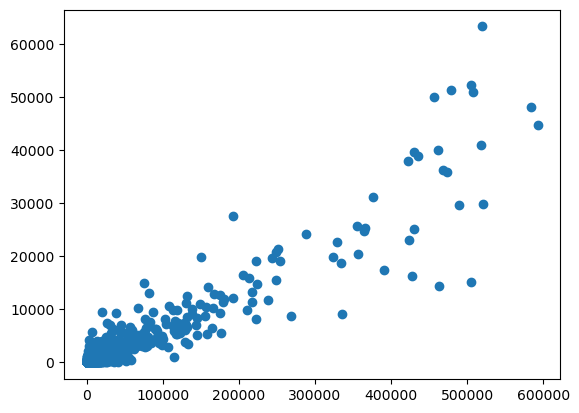

In [206]:
fig, ax = plt.subplots()
ax.scatter(movcell_baseline_imput_pop['population'], movcell_baseline_imput_pop['5'])
plt.show()

In [ ]:
n_class_density = 5

movcell_baseline_imput_pop['density'] = movcell_baseline_imput_pop['population']/(movcell_baseline_imput_pop['geometry'].to_crs('EPSG:3857').area/1000000)
breaks_density = jenkspy.jenks_breaks(movcell_baseline_imput_pop.dropna(subset=['density'])['density'], n_classes=n_class_density)
breaks_density[0] = breaks_density[0]-10**(-10)
movcell_baseline_imput_pop['class_density'] = pd.qcut(movcell_baseline_imput_pop['density'], q=n_class_density, labels=[i for i in range(n_class_density)])#, bins=breaks_density, labels=[i for i in range(n_class_density)])
movcell_baseline_imput_pop['class_density'] = pd.cut(movcell_baseline_imput_pop['density'], bins=breaks_density, labels=[i for i in range(n_class_density)])#, bins=breaks_density, labels=[i for i in range(n_class_density)])
movcell_baseline_imput_pop['class_density'] = pd.to_numeric(movcell_baseline_imput_pop['class_density'])

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

if country != 'Mexico':
    background = gpd.read_file(wd + '/data/inputs/boundaries/south-america/vc965bq8111.shp').to_crs('EPSG:4326')
else:
    background = gpd.read_file(wd + '/data/inputs/boundaries/central-america/bound_p.shp').to_crs('EPSG:4326')

background.plot(ax=ax, facecolor='dimgray', alpha=0.5, zorder=1)
if country != 'Mexico':
    background[background['name']==country.upper()].plot(ax=ax, color='None', zorder=2)
else:
    shape = gpd.read_file(wd + '/data/inputs/boundaries/gadm41_MEX_2.json').to_crs('EPSG:4326')
    shape.plot(ax=ax, color='None', zorder=2)
ax.set_facecolor('lightskyblue')
    
movcell_baseline_imput_pop.plot(column = 'density', cmap='viridis', scheme='natural_breaks', k=5, 
                                legend=False, zorder=2, ax=ax)
# movcell_baseline_imput_pop.plot(column = 'class_density', cmap='viridis', ax=ax, legend=True)

if country == 'Argentina':
    ax.set_xlim(-77,-49)
    ax.set_ylim(-57,-16)
elif country == 'Chile':
    ax.set_xlim(-77,-49)
    ax.set_ylim(-57,-16)
elif country == 'Colombia':
    ax.set_xlim(-80,-64)
    ax.set_ylim(-5.5,13.5)
elif country == 'Mexico':
    ax.set_xlim(-119,-85)
    ax.set_ylim(10,38)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k',  labelleft=False, labelbottom=False)
    
labels_density = breaks_density    
custom_labels = []
for i in range(n_class_density-1):
    custom_labels.append('['+str(int(labels_density[i]))+', '+ str(int(labels_density[i+1]))+')')
for i in range(n_class_density-1, n_class_density):
    custom_labels.append('['+str(int(labels_density[i]))+', '+ str(int(labels_density[i+1]))+']')
colors=mcp.gen_color(cmap='viridis', n=n_class_density)
legend_elements = [Line2D([0], [0], lw=0, color=colors[i],
                          marker='o', markersize=10, label=custom_labels[i]) for i in range(len(colors))]

if country == 'Argentina':
    loc='lower right'#(0.51,0.07)
elif country == 'Chile':
    loc='lower right'#(0.51,0.07)
elif country == 'Colombia':
    loc='lower right'#(0.51,0.07)
elif country == 'Mexico':
    loc='lower left'#(0.52,0.33)
# legend = ax.legend(handles=legend_elements, handlelength=0, fontsize = 14, shadow=False,
#                    fancybox= False, loc=loc, ncol=1, columnspacing=1.2, 
#                    borderpad=1, title = 'Population density from \nWorlPop (persons/sqkm)')
# for t in legend.get_texts():
#     t.set_ha('right')
# legend.get_frame().set_edgecolor('black')
# legend.get_frame().set_linewidth(1)
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 0.7))
# legend.get_title().set_fontsize('14')

# ax.add_artist(ScaleBar(dx=1,units="km",dimension="si-length",length_fraction=.1, 
#                    scale_formatter=lambda value, unit: f' {value * 100} km ', 
#                    pad=0.7, sep=5, border_pad = 1, scale_loc='top', box_color='w', box_alpha=0, font_properties={'size':20}, location='upper left'))

# im = plt.imread(wd + '/data/inputs/boundaries/north-arrow.png')

# if country == 'Argentina':
#     loc_arr1 = [0.655,0.82,0.04,0.04]
# elif country == 'Chile':
#     loc_arr1 = [0.655,0.82,0.04,0.04]
# elif country == 'Colombia':
#     loc_arr1 = [0.755,0.82,0.04,0.04]
# elif country == 'Mexico':
#     loc_arr1 = [0.83,0.78,0.04,0.04]

# newax = fig.add_axes(loc_arr1, zorder=1)
# newax.tick_params(axis = 'both', which = 'both', labelbottom=False, labelleft=False, width = 0, length = 0)
# newax.set_facecolor('None')
# plt.setp(newax.spines.values(), linewidth=0)
# newax.imshow(im)

plt.savefig(wd + '/plots/map-classes/map-classes-density-' + country_short + '-nolegend.pdf', bbox_inches = 'tight')   
    
plt.show()

### Add level of RDI

In [207]:
# # Only uncomment if you want to reread the rdi raster and generate a gpkg with point geometries
# # Import rdi raster and turn it into geodataframe of points based on centroids of pixels

# file_raster = wd + '/data/inputs/rdi/povmap-grdi-v1-grdiv1-geotiff/povmap-grdi-v1.tif'

# rds = rx.open_rasterio(file_raster)
# rds.name = "rdi"
# df_rdi = rds.squeeze().to_dataframe().reset_index()

# df_rdi = df_rdi[df_rdi['rdi']>=0].reset_index(drop=True)

# geometry = gpd.points_from_xy(df_rdi.x, df_rdi.y)
# gdf_rdi = gpd.GeoDataFrame(df_rdi, crs=rds.rio.crs, geometry=geometry)
# gdf_rdi = gdf_rdi.drop(['y', 'x', 'band', 'spatial_ref'], axis = 1)

# gdf_rdi = gdf_rdi.to_crs('epsg:4326')

In [208]:
grid_rdi_join = gpd.sjoin(movcell_baseline_imput_pop, gdf_rdi)
grid_rdi_join = grid_rdi_join.dropna(subset=['rdi'])
grid_rdi_group = grid_rdi_join[['rdi']].groupby(grid_rdi_join[['rdi']].index).mean()
movcell_baseline_imput_pop = pd.merge(movcell_baseline_imput_pop, grid_rdi_group, how='left', left_index=True, right_index=True)


In [209]:
# imput average rdi of neighbours when rdi is NaN. But I think it doesn't work, so just set 'rdi_imput' to 'rdi'

# movcell_baseline_imput_pop['FID'] = movcell_baseline_imput_pop.index
# w_queen = weights.Queen.from_dataframe(movcell_baseline_imput_pop, idVariable="FID")
# w_queen.transform ='R'
# movcell_baseline_imput_pop['rdi_w'] = weights.lag_spatial(w_queen, movcell_baseline_imput_pop['rdi'])#.fillna(0))

# movcell_baseline_imput_pop['rdi_imput'] = [np.nan for i in range(len(movcell_baseline_imput_pop))]

# for i in range(len(movcell_baseline_imput_pop)):
#     if pd.isna(movcell_baseline_imput_pop.loc[i, 'rdi']):
#         if movcell_baseline_imput_pop.loc[i, 'rdi_w'] != 0:
#             movcell_baseline_imput_pop.loc[i, 'rdi_imput'] = movcell_baseline_imput_pop.loc[i, 'rdi_w']
#     else:
#         movcell_baseline_imput_pop.loc[i, 'rdi_imput'] = movcell_baseline_imput_pop.loc[i, 'rdi']

# movcell_baseline_imput_pop = movcell_baseline_imput_pop.drop(['FID', 'rdi_w'], axis=1)


movcell_baseline_imput_pop['rdi_imput'] = movcell_baseline_imput_pop['rdi']

In [210]:
n_class_rdi = 3

breaks_rdi = jenkspy.jenks_breaks(movcell_baseline_imput_pop.dropna(subset=['rdi'])['rdi'], n_classes=n_class_rdi)
breaks_rdi[0] = breaks_rdi[0]-10**(-10)
# movcell_baseline_imput_pop['class_rdi'] = pd.qcut(movcell_baseline_imput_pop['rdi'], q=n_class_rdi, labels=[i for i in range(n_class_rdi)])
movcell_baseline_imput_pop['class_rdi'] = pd.cut(movcell_baseline_imput_pop['rdi'], bins=breaks_rdi, labels=[i for i in range(n_class_rdi)])
movcell_baseline_imput_pop['class_rdi'] = pd.to_numeric(movcell_baseline_imput_pop['class_rdi'])


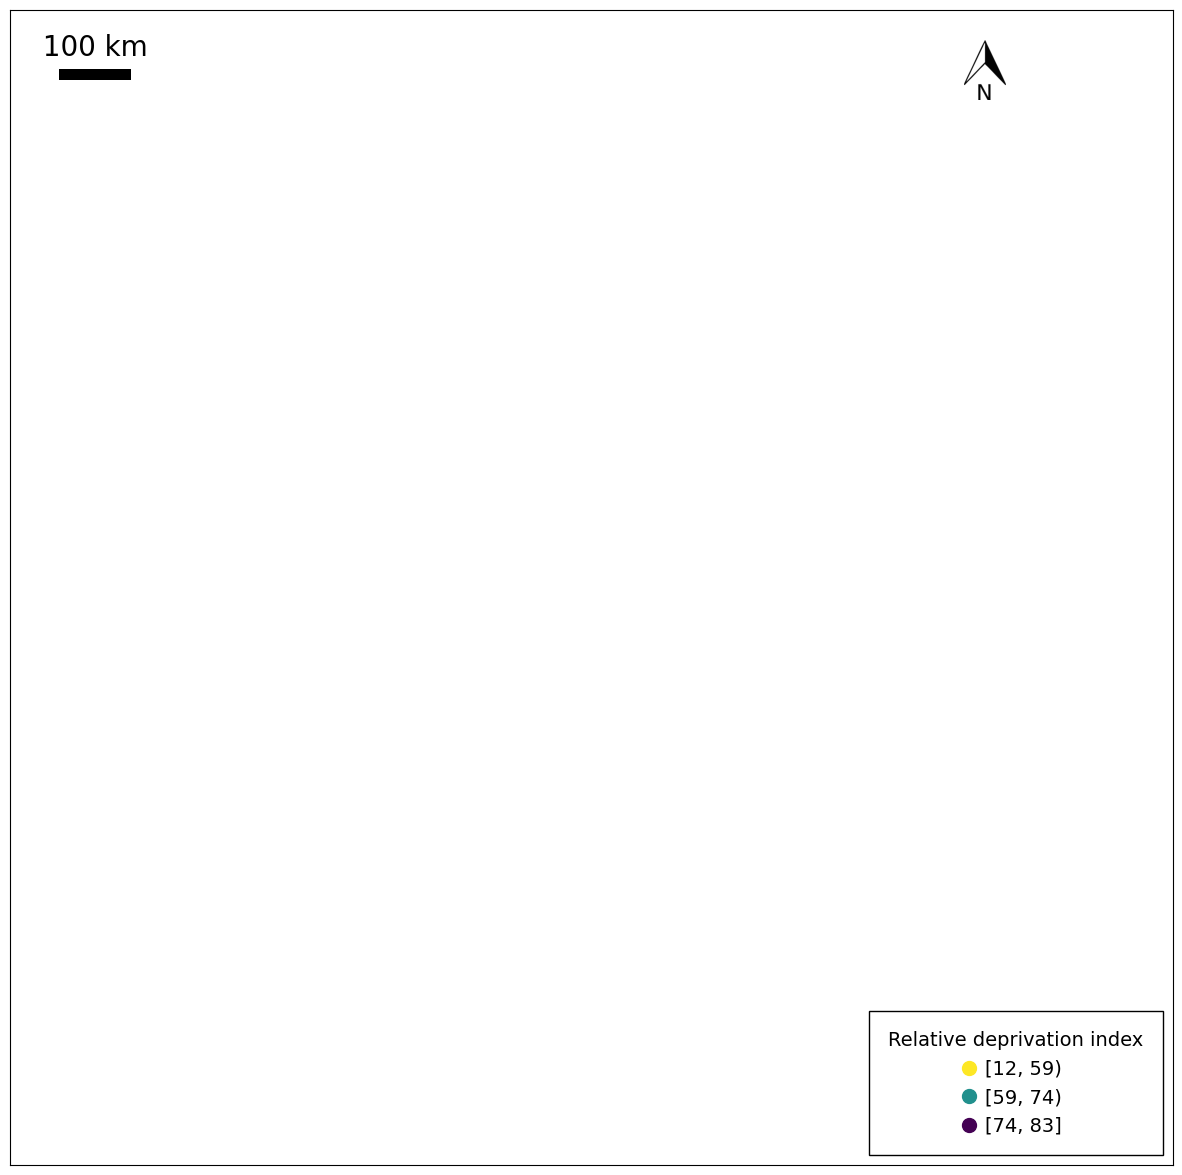

In [211]:
fig, ax = plt.subplots(figsize=(15,15))

if country != 'Mexico':
    background = gpd.read_file(wd + '/data/inputs/boundaries/south-america/vc965bq8111.shp').to_crs('EPSG:4326')
else:
    background = gpd.read_file(wd + '/data/inputs/boundaries/central-america/bound_p.shp').to_crs('EPSG:4326')

# background.plot(ax=ax, facecolor='dimgray', alpha=0.5, zorder=1)
# if country != 'Mexico':
#     background[background['name']==country.upper()].plot(ax=ax, color='None', zorder=2)
# else:
#     shape = gpd.read_file(wd + '/data/inputs/boundaries/gadm41_MEX_2.json').to_crs('EPSG:4326')
#     shape.plot(ax=ax, color='None', zorder=2)
# ax.set_facecolor('lightskyblue')
    
# movcell_baseline_imput_pop['class_rdi_plot'] = movcell_baseline_imput_pop['class_rdi']
# for i in range(len(movcell_baseline_imput_pop)):
#     if pd.isna(movcell_baseline_imput_pop.loc[i, 'class_rdi_plot']):
#         movcell_baseline_imput_pop.loc[i, 'class_rdi_plot'] = 2
# movcell_baseline_imput_pop.plot(column = 'class_rdi_plot', cmap='viridis_r', k=3, legend=False, zorder=2, ax=ax)
# movcell_baseline_imput_pop.drop(['class_rdi_plot'], axis=1)

# movcell_baseline_imput_pop.plot(column = 'class_rdi', cmap='viridis_r', ax=ax, legend=False)

if country == 'Argentina':
    ax.set_xlim(-77,-49)
    ax.set_ylim(-57,-16)
elif country == 'Chile':
    ax.set_xlim(-77,-49)
    ax.set_ylim(-57,-16)
elif country == 'Colombia':
    ax.set_xlim(-80,-64)
    ax.set_ylim(-5.5,13.5)
elif country == 'Mexico':
    ax.set_xlim(-119,-85)
    ax.set_ylim(10,38)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k',  labelleft=False, labelbottom=False)
    
labels_rdi = breaks_rdi   
custom_labels = []
for i in range(n_class_rdi-1):
    custom_labels.append('['+str(int(labels_rdi[i]))+', '+ str(int(labels_rdi[i+1]))+')')
for i in range(n_class_rdi-1, n_class_rdi):
    custom_labels.append('['+str(int(labels_rdi[i]))+', '+ str(int(labels_rdi[i+1]))+']')
colors=mcp.gen_color(cmap='viridis_r', n=n_class_rdi)
legend_elements = [Line2D([0], [0], lw=0, color=colors[i],
                          marker='o', markersize=10, label=custom_labels[i]) for i in range(len(colors))]

if country == 'Argentina':
    loc='lower right'#(0.51,0.07)
elif country == 'Chile':
    loc='lower right'#(0.51,0.07)
elif country == 'Colombia':
    loc='lower right'#(0.51,0.07)
elif country == 'Mexico':
    loc='lower left'#(0.52,0.33)
legend = ax.legend(handles=legend_elements, handlelength=0, fontsize = 14, shadow=False,
                   fancybox= False, loc=loc, ncol=1, columnspacing=1.2, 
                   borderpad=1, title = 'Relative deprivation index')
for t in legend.get_texts():
    t.set_ha('right')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.7))
legend.get_title().set_fontsize('14')

ax.add_artist(ScaleBar(dx=1,units="km",dimension="si-length",length_fraction=.1, 
                   scale_formatter=lambda value, unit: f' {value * 100} km ', 
                   pad=0.7, sep=5, border_pad = 1, scale_loc='top', box_color='w', box_alpha=0, font_properties={'size':20}, location='upper left'))

im = plt.imread(wd + '/data/inputs/boundaries/north-arrow.png')

if country == 'Argentina':
    loc_arr1 = [0.655,0.82,0.04,0.04]
elif country == 'Chile':
    loc_arr1 = [0.655,0.82,0.04,0.04]
elif country == 'Colombia':
    loc_arr1 = [0.755,0.82,0.04,0.04]
elif country == 'Mexico':
    loc_arr1 = [0.83,0.78,0.04,0.04]

newax = fig.add_axes(loc_arr1, zorder=1)
newax.tick_params(axis = 'both', which = 'both', labelbottom=False, labelleft=False, width = 0, length = 0)
newax.set_facecolor('None')
plt.setp(newax.spines.values(), linewidth=0)
newax.imshow(im)


plt.savefig(wd + '/plots/map-classes/map-classes-rdi-' + country_short + '-scalelegend.pdf', bbox_inches = 'tight') 
    
plt.show()

## Percentage population in each category

In [ ]:
average_week = []
for i in range(len(movcell_baseline_imput_pop)):
    average_week.append(np.mean(movcell_baseline_imput_pop.iloc[i, [0,1,2,3,4,5,6]]))

movcell_baseline_imput_pop['average_week'] = average_week

fb_pop_class_density = []
wp_pop_class_density = []
for i in range(n_class_density):
    fb_pop_class_density.append(np.sum(movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_density']==i]['average_week']))
    wp_pop_class_density.append(np.sum(movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_density']==i]['population']))

fb_pop_class_density_per = fb_pop_class_density/np.sum(fb_pop_class_density)*100
wp_pop_class_density_per = wp_pop_class_density/np.sum(wp_pop_class_density)*100


fb_pop_class_rdi = []
wp_pop_class_rdi = []
for i in range(n_class_rdi):
    fb_pop_class_rdi.append(np.sum(movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_density']==i]['average_week']))
    wp_pop_class_rdi.append(np.sum(movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_density']==i]['population']))

fb_pop_class_rdi_per = fb_pop_class_rdi/np.sum(fb_pop_class_rdi)*100
wp_pop_class_rdi_per = wp_pop_class_rdi/np.sum(wp_pop_class_rdi)*100

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

fb_pop_class_density_lim = [np.sum(fb_pop_class_density_per[0:i]) for i in range(len(fb_pop_class_density_per))]
ax.barh(3, width = fb_pop_class_density_per, left = fb_pop_class_density_lim, color = mcp.gen_color(cmap='viridis', n=n_class_density))
wp_pop_class_density_lim = [np.sum(wp_pop_class_density_per[0:i]) for i in range(len(wp_pop_class_density_per))]
ax.barh(4, width = wp_pop_class_density_per, left = wp_pop_class_density_lim, color = mcp.gen_color(cmap='viridis', n=n_class_density))

fb_pop_class_rdi_lim = [np.sum(fb_pop_class_rdi_per[0:i]) for i in range(len(fb_pop_class_rdi_per))]
ax.barh(1, width = fb_pop_class_rdi_per, left = fb_pop_class_rdi_lim, color = mcp.gen_color(cmap='viridis', n=n_class_rdi))
wp_pop_class_rdi_lim = [np.sum(wp_pop_class_rdi_per[0:i]) for i in range(len(wp_pop_class_rdi_per))]
ax.barh(2, width = wp_pop_class_rdi_per, left = wp_pop_class_rdi_lim, color = mcp.gen_color(cmap='viridis', n=n_class_rdi))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', rotation=0, length=0, labelsize=20, labelleft=False, labelbottom=True)

plt.savefig(wd + '/plots/percentage-classes/percentage-classes-' + country_short + '.pdf', bbox_inches = 'tight') 

In [ ]:
# Add class of movcell based on density class and RDI class

n_class = 0

n_class_labels = {}
for i in range(n_class_density):
    for j in range(n_class_rdi):
        n_class += 1
        n_class_labels[n_class-1] = [i, j]
print(n_class_labels)

movcell_baseline_imput_pop['n_class_label'] = np.zeros(len(movcell_baseline_imput_pop))

for i in range(len(movcell_baseline_imput_pop)):
    pair = [movcell_baseline_imput_pop.loc[i, 'class_density'], movcell_baseline_imput_pop.loc[i, 'class_rdi']]
    if len([key for key, value in n_class_labels.items() if value == pair]) == 0:
        movcell_baseline_imput_pop.loc[i, 'n_class_label'] = np.nan
    else:
        movcell_baseline_imput_pop.loc[i, 'n_class_label'] = [key for key, value in n_class_labels.items() if value == pair][0]
    

In [ ]:
np.unique(movcell_baseline_imput_pop['n_class_label'])

In [ ]:
movcell_baseline_imput_pop.to_file(wd + '/data/outputs/' + country_short + '/grids-with-data/movcell-baseline-imput-pop-with-exo-var/movcell-baseline-imput-pop-with-exo-var.gpkg')




In [ ]:
# DUMMY VARIABLES: https://www.statlect.com/fundamentals-of-statistics/dummy-variable

In [95]:
movcell_baseline_imput_pop

,0,1,2,3,4,5,6,geometry,population,density,class_density,rdi,rdi_imput,class_rdi,rdi_imput_plot,n_class_label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-69.96094 -4.21494, -69.96094 -4.216...",NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-69.96094 -4.21494, -69.92853 -4.214...",NaN,NaN,NaN,38.426247,38.426247,0.0,38.426247,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-70.00488 -4.17112, -70.00488 -4.191...",86.369087,54.119202,0.0,NaN,NaN,NaN,0.000000,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-70.00488 -4.17112, -69.96094 -4.171...",1949.861694,96.718782,0.0,79.767372,79.767372,2.0,79.767372,2.0
4,976.637078,981.820558,969.339036,972.437329,959.101578,941.713506,927.32902,"POLYGON ((-69.96094 -4.21494, -69.96094 -4.171...",17733.955078,880.899039,1.0,46.019585,46.019585,0.0,46.019585,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-79.73437 15.86627, -79.73682 15.863...",NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
49320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-78.68076 15.83453, -78.68048 ...",NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
49321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-78.63568 15.85669, -78.63818 15.854...",NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
49322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-79.72082 15.89630, -79.71942 15.897...",NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN


<Axes: >

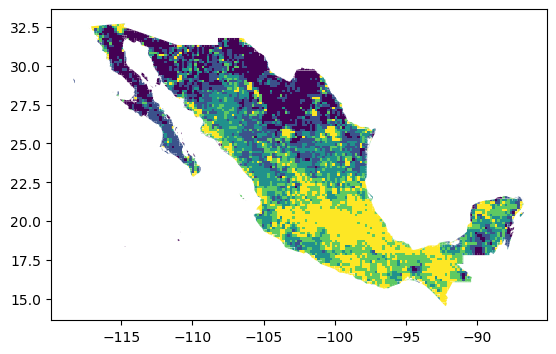

In [36]:
movcell_baseline_imput_pop.plot(column = 'class_density')